# CoastSat.slope: Narrabeen-Collaroy example

_This notebook is from the [CoastSat toolbox](https://github.com/kvos/CoastSat)._


This is an extention of the main [CoastSat toolbox](https://github.com/kvos/CoastSat) and it is assumed that the user is familiar with CoastSat as the outputs of CoastSat are used here to estimate beach slopes. 
The `coastsat` environment also needs to be installed before attempting this example.

This example shows how to estimate the beach slope along 5 transects at Narrabeen-Collaroy, Sydney, Australia.

## Initial settings

In [17]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import pickle
# beach slope estmation module
import SDS_slope

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load satellite-derived shorelines and transect locations

:::{note}
**Satellite-derived shorelines from Landsat 5, 7 and 8 between 1999 and 2020 are needed to estimate the beach slope**, these have to be mapped with CoastSat beforehand. When mapping shorelines with CoastSat, the coordinates of the 2D shorelines are saved in a file named `sitename_output.pkl`.
:::

In this example we use 2 files that are under *example_data/* (you will need the same files for another site):
* `NARRA_output.pkl`: satellite-derived shorelines mapped from 1999-2020 using Landsat 5,7 and 8 (no Sentinel-2)

* `NARRA_transects.geojson`: cross-shore transect coordinates (2 points, the first one being landwards)

The section below loads the two files, removes duplicates and shorelines with poor georeferencing and plots the 2D shorelines and cross-shore transects.

5 transects have been loaded
1 duplicates
0 bad georef


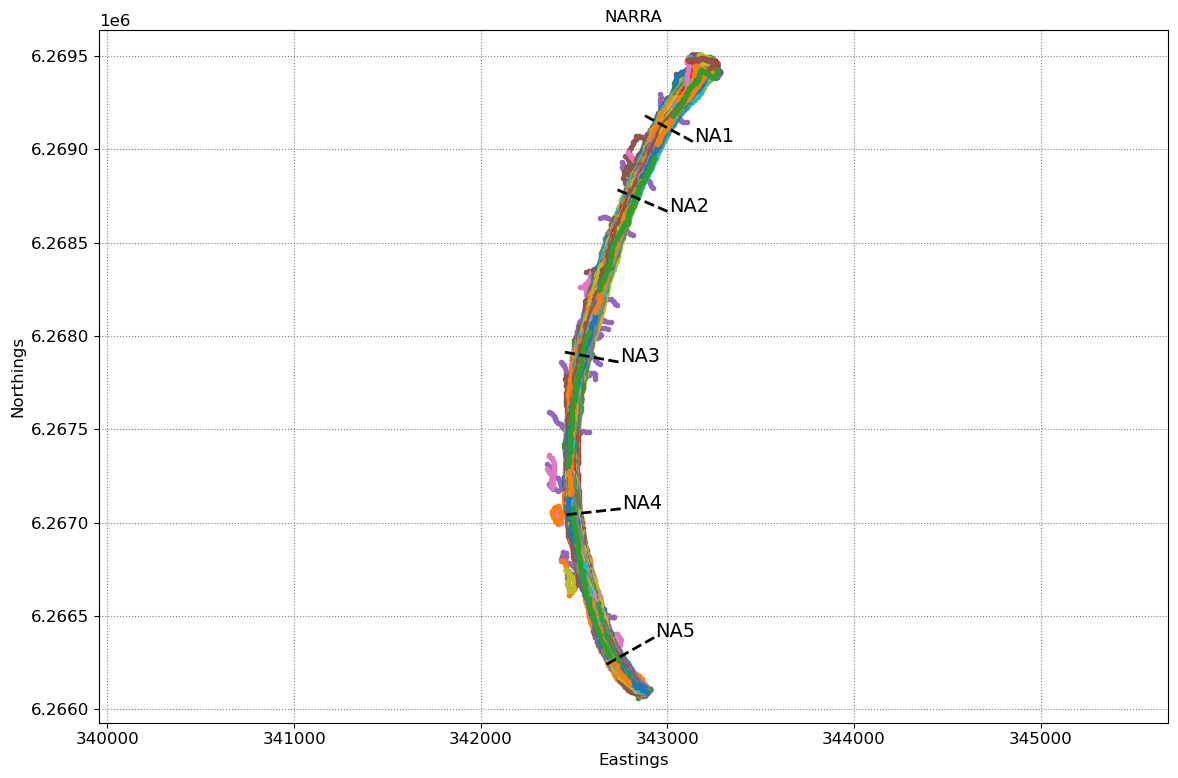

In [18]:
# load the sitename_output.pkl generated by CoastSat
sitename = 'NARRA'
with open(os.path.join('example_data', sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f) 
    
# load the 2D transects from geojson file
geojson_file = os.path.join(os.getcwd(), 'example_data', sitename + '_transects.geojson')
transects = SDS_slope.transects_from_geojson(geojson_file)

# remove S2 shorelines (the slope estimation algorithm needs only Landsat shorelines)
if 'S2' in output['satname']:
    idx_S2 = np.array([_ == 'S2' for _ in output['satname']])
    for key in output.keys():
        output[key] = [output[key][_] for _ in np.where(~idx_S2)[0]]

# remove duplicates (can happen that images overlap and there are 2 shorelines for the same date)
output = SDS_slope.remove_duplicates(output)
# remove shorelines from images with poor georeferencing (RMSE > 10 m)
output = SDS_slope.remove_inaccurate_georef(output, 10)

# plot shorelines and transects
fig,ax = plt.subplots(1,1,figsize=[12,  8])
fig.set_tight_layout(True)
ax.axis('equal')
ax.set(xlabel='Eastings', ylabel='Northings', title=sitename)
ax.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    coords = output['shorelines'][i]
    date = output['dates'][i]
    ax.plot(coords[:,0], coords[:,1], '.', label=date.strftime('%d-%m-%Y'))
for key in transects.keys():
    ax.plot(transects[key][:,0],transects[key][:,1],'k--',lw=2)
    ax.text(transects[key][-1,0], transects[key][-1,1], key)

## 2. Extract time-series of shoreline change along the transects

:::{note}
To obtain time-series of shoreline change we need to calculate the intersections between the 2D shorelines and the cross-shore transects, this can be done in the CoastSat toolbox but I provided here a more advanced method that deals with outliers and erroneous detections. As the accuracy of the beach slope estimate will depend on the quality of the satellite-derived shorelines, it is important to get rid of large outliers as these will affect the slope estimates.
:::

To remove outliers use the `max_cross_change` parameter to define the maximum cross-shore distance for despiking the time-series. Narrabeen-Collaroy is microtidal and storm-dominated, therefore the threshold was set at 40 m.

NA1  - outliers removed 0
NA2  - outliers removed 0
NA3  - outliers removed 0
NA4  - outliers removed 0
NA5  - outliers removed 0


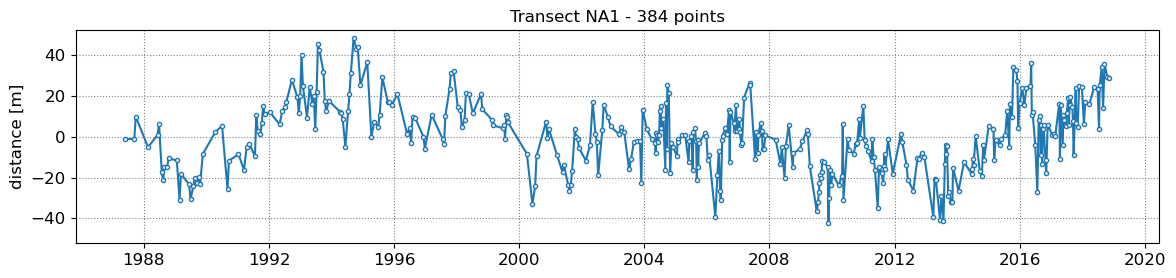

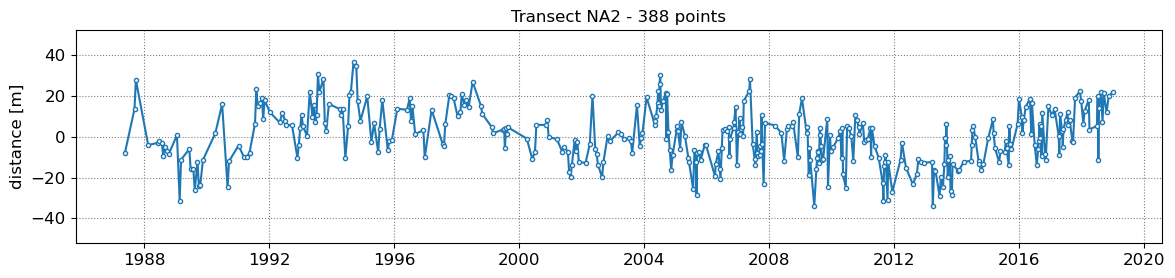

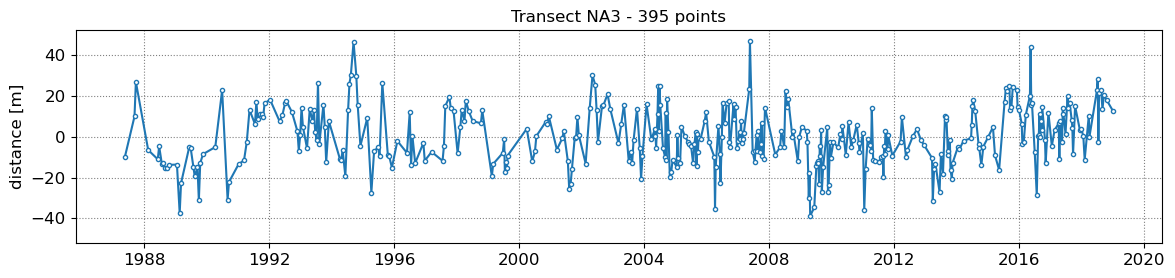

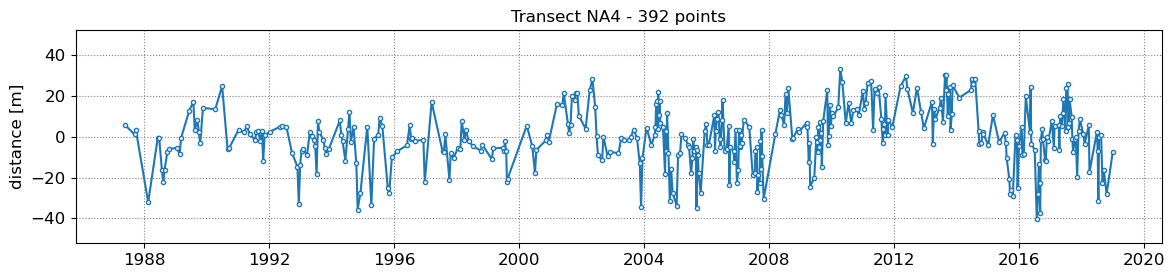

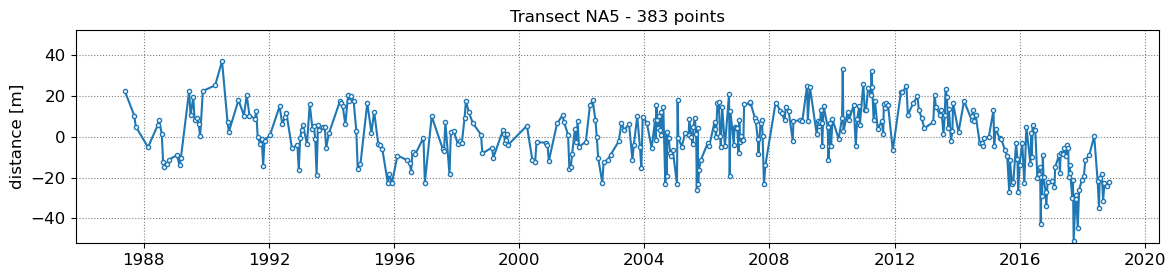

In [19]:
# a more robust method to compute intersections is provided here to avoid the presence of outliers in the time-series
settings_transects = { # parameters for shoreline intersections
                      'along_dist':         25,         # along-shore distance to use for intersection
                      'max_std':            15,         # max std for points around transect
                      'max_range':          30,         # max range for points around transect
                      'min_val':            -100,       # largest negative value along transect (landwards of transect origin)
                      # parameters for outlier removal
                      'nan/max':            'auto',     # mode for removing outliers ('auto', 'nan', 'max')
                      'prc_std':            0.1,        # percentage to use in 'auto' mode to switch from 'nan' to 'max'
                      'max_cross_change':   40,         # maximum cross-shore distance for despiking
                      }
# compute intersections [advanced version]
cross_distance = SDS_slope.compute_intersection(output, transects, settings_transects) 
# remove outliers [advanced version]
cross_distance = SDS_slope.reject_outliers(cross_distance,output,settings_transects)        
# plot time-series
SDS_slope.plot_cross_distance(output['dates'],cross_distance)

## 3. Get tide levels at the time of image acquisition

Now that we have the time-series of shoreline change, we need to obtain the tide level at the time of image acquisition for each data point. 

In the section below, the time-series of shoreline change are cropped between 1999 and 2000 as this is the period when 2 Landsat satellites are concurrently in orbit (providing a minimum sampling period of 8 days).

In [20]:
# slope estimation settings
days_in_year = 365.2425
seconds_in_day = 24*3600
settings_slope = {'slope_min':        0.035,                  # minimum slope to trial
                  'slope_max':        0.2,                    # maximum slope to trial
                  'delta_slope':      0.005,                  # slope increment
                  'date_range':       [1999,2020],            # range of dates over which to perform the analysis
                  'n_days':           8,                      # sampling period [days]
                  'n0':               50,                     # parameter for Nyquist criterium in Lomb-Scargle transforms
                  'freqs_cutoff':     1./(seconds_in_day*30), # 1 month frequency
                  'delta_f':          100*1e-10,              # deltaf for identifying peak tidal frequency band
                  }
settings_slope['date_range'] = [pytz.utc.localize(datetime(settings_slope['date_range'][0],5,1)),
                                pytz.utc.localize(datetime(settings_slope['date_range'][1],1,1))]
beach_slopes = SDS_slope.range_slopes(settings_slope['slope_min'], settings_slope['slope_max'], settings_slope['delta_slope'])

# clip the dates between 1999 and 2020 as we need at least 2 Landsat satellites 
idx_dates = [np.logical_and(_>settings_slope['date_range'][0],_<settings_slope['date_range'][1]) for _ in output['dates']]
dates_sat = [output['dates'][_] for _ in np.where(idx_dates)[0]]
for key in cross_distance.keys():
    cross_distance[key] = cross_distance[key][idx_dates]

In [22]:
# Load tide levels corresponding to "dates_sat" from a file
with open(os.path.join('example_data', sitename + '_tide' + '.pkl'), 'rb') as f:
    tide_data = pickle.load(f) 
tide_sat = tide_data['tide']

## 4. Peak tidal frequency

Find the peak tidal frequency, frequency band at which the energy is the largest in the subsampled tide level time-series. 

:::{caution}
Most sites will have a minimum sampling period of 8 days, but it can happen that because of overlapping images at some sites, a minimum sampling period of 7 days is achieved, then you can use 7 days instead of 8 by setting `settings_slope['n_days] = 7`. Don't use a sampling period of less than 7 days. If the plot of timestep distribution doesn't show a peak at 7 or 8 days, you will not be able to apply this technique as you don't have enough images.
:::

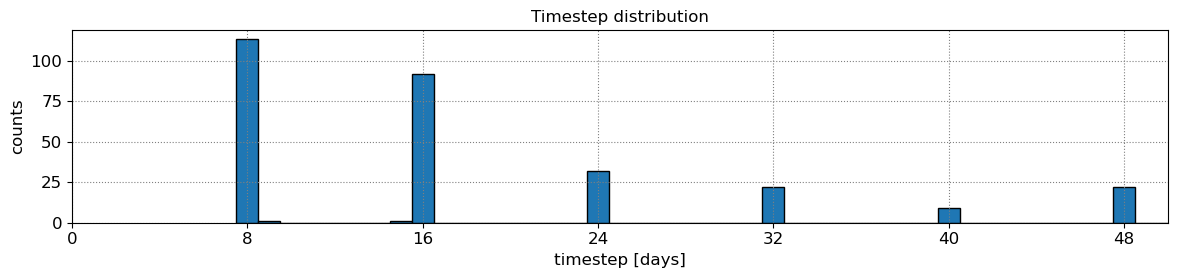

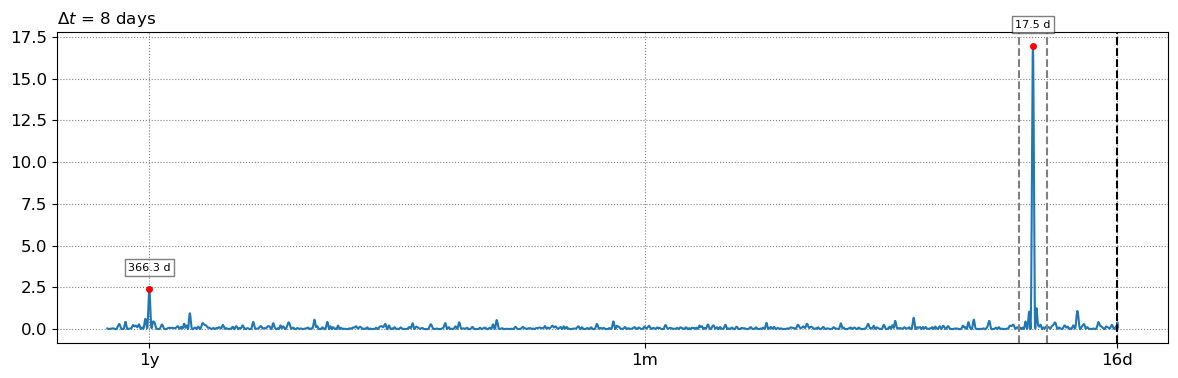

In [23]:
# plot time-step distribution
t = np.array([_.timestamp() for _ in dates_sat]).astype('float64')
delta_t = np.diff(t)
fig, ax = plt.subplots(1,1,figsize=(12,3), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
bins = np.arange(np.min(delta_t)/seconds_in_day, np.max(delta_t)/seconds_in_day+1,1)-0.5
ax.hist(delta_t/seconds_in_day, bins=bins, ec='k', width=1);
ax.set(xlabel='timestep [days]', ylabel='counts',
       xticks=settings_slope['n_days']*np.arange(0,20),
       xlim=[0,50], title='Timestep distribution');

# find tidal peak frequency
settings_slope['n_days'] = 8
settings_slope['freqs_max'] = SDS_slope.find_tide_peak(dates_sat,tide_sat,settings_slope)

## 5. Estimate the beach slope

The beach slope along each transect is estimated by finding the slope that, when used for tidal correction, minimises the energy in the peak tidal frequency band. Based on our validation study, this slopes corresponds to the beach-face slope between mean sea level (MSL) and mean high water springs (MHWS).

Beach slope at transect NA1: 0.075
Beach slope at transect NA2: 0.095
Beach slope at transect NA3: 0.080
Beach slope at transect NA4: 0.080
Beach slope at transect NA5: 0.095


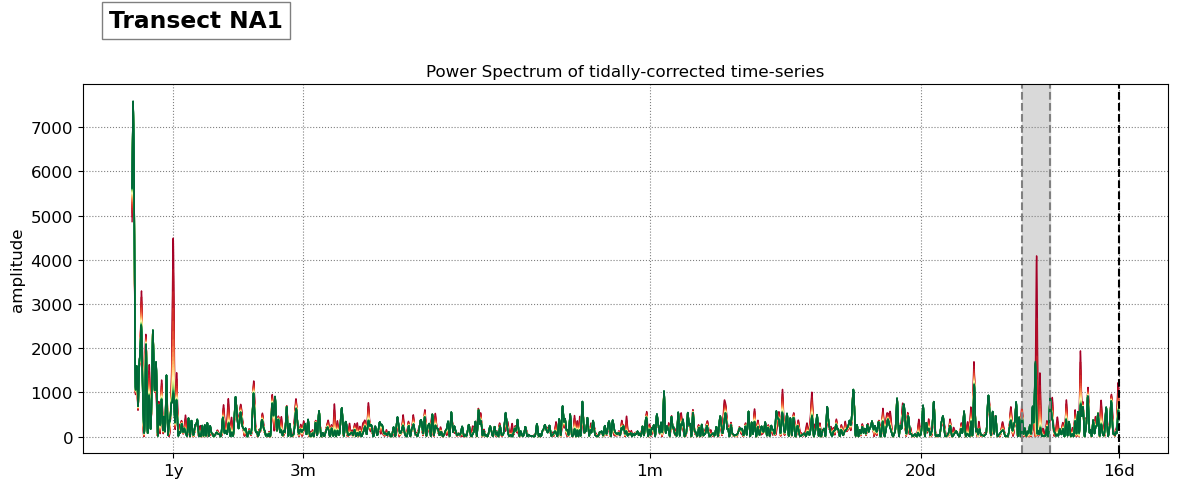

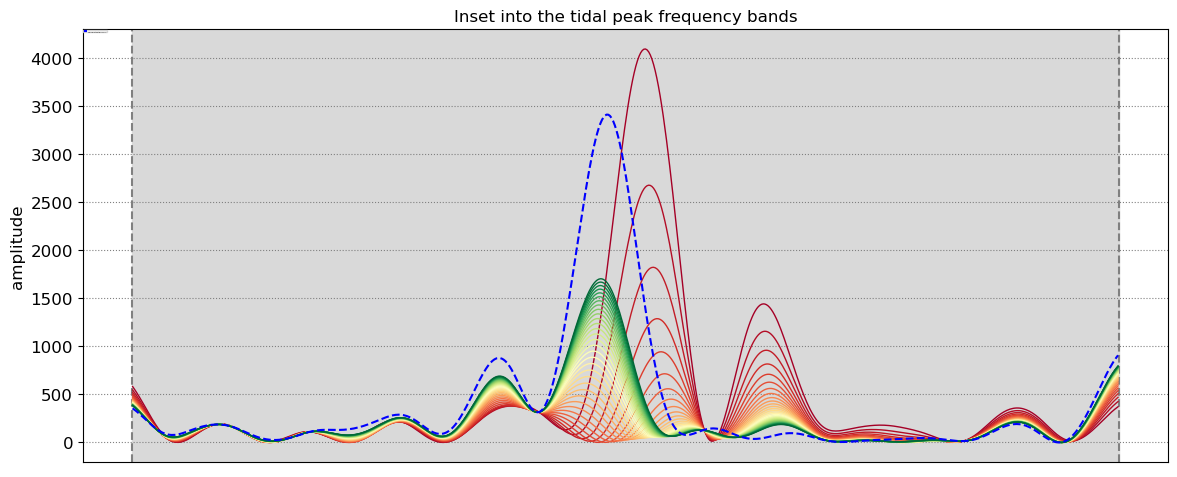

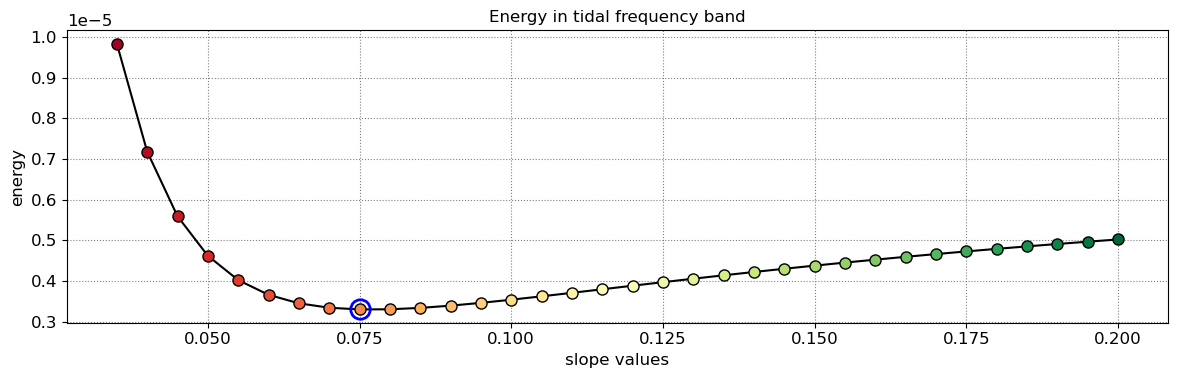

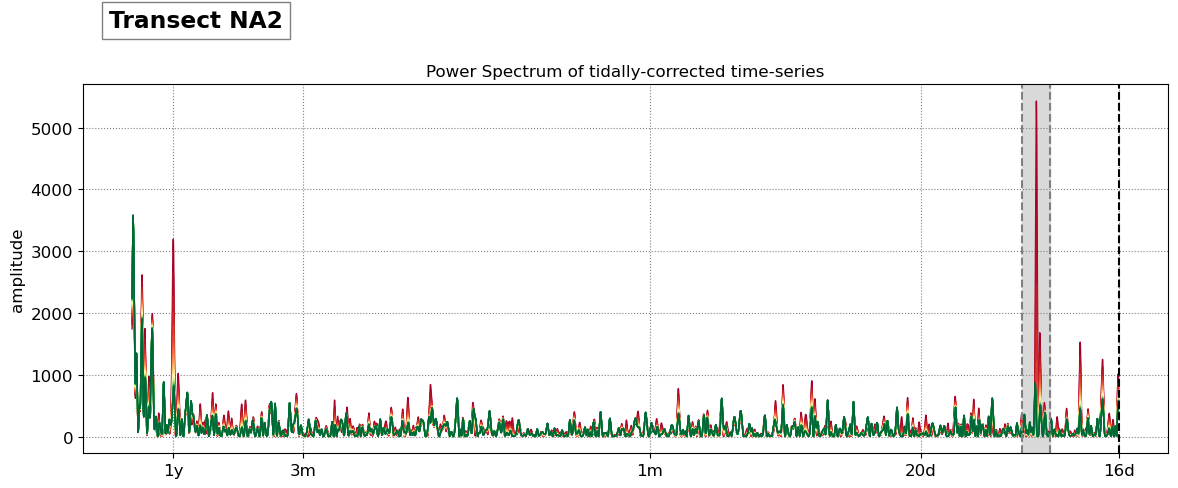

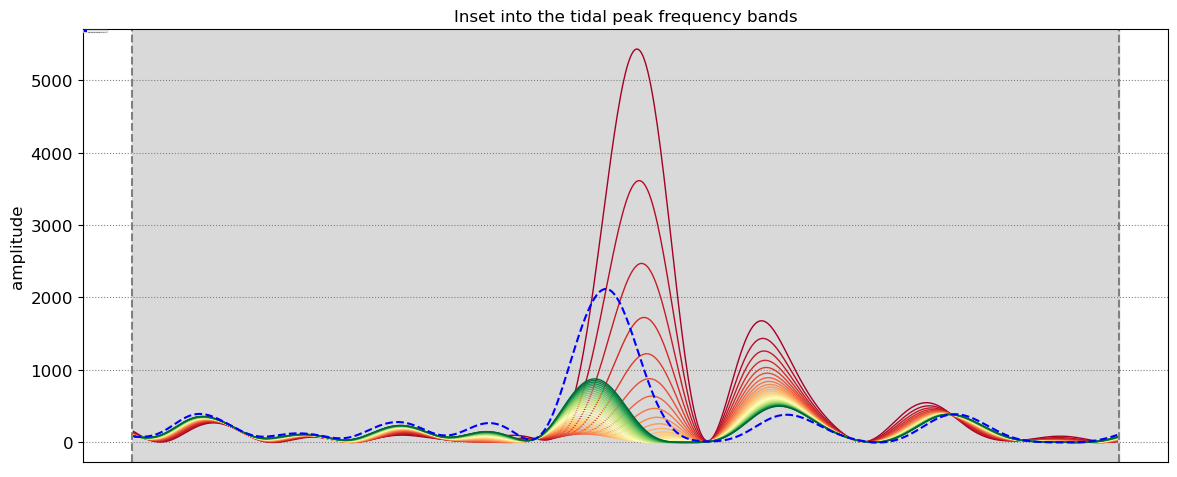

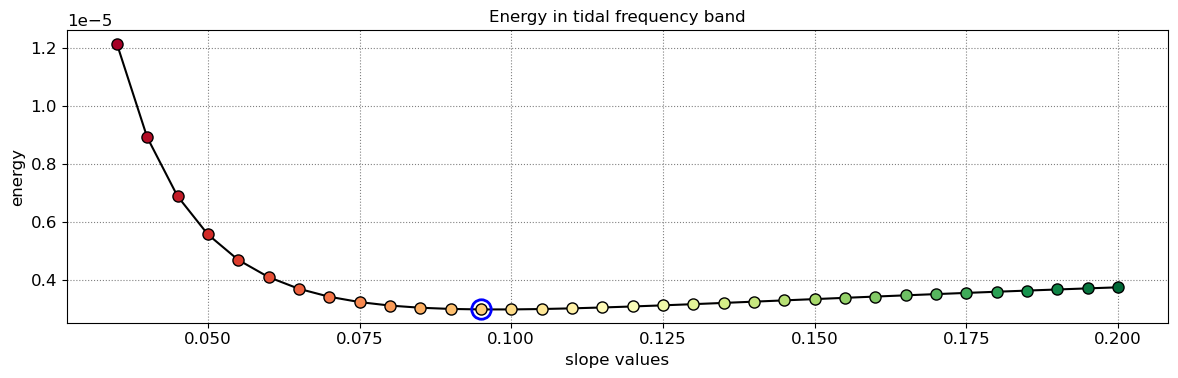

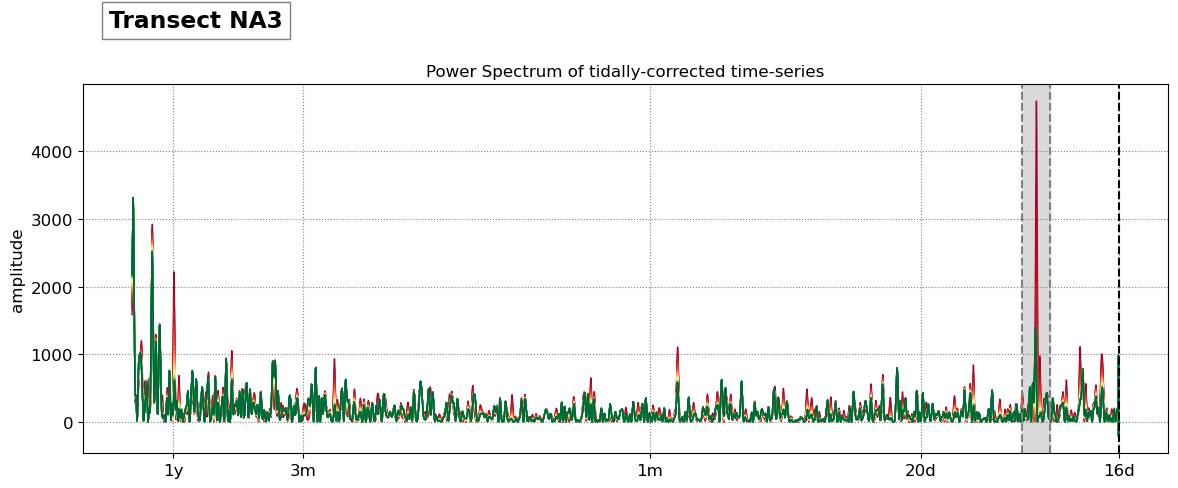

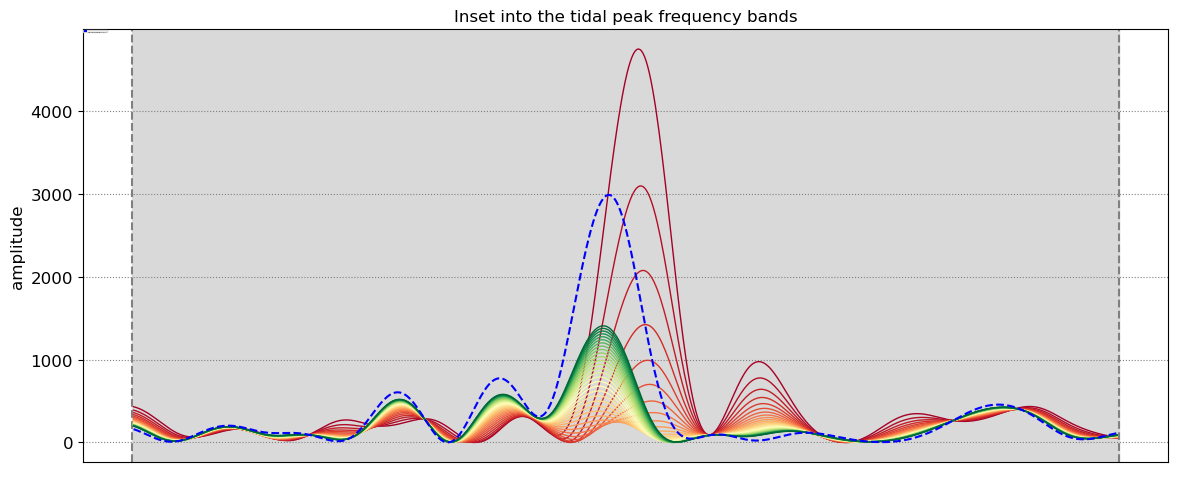

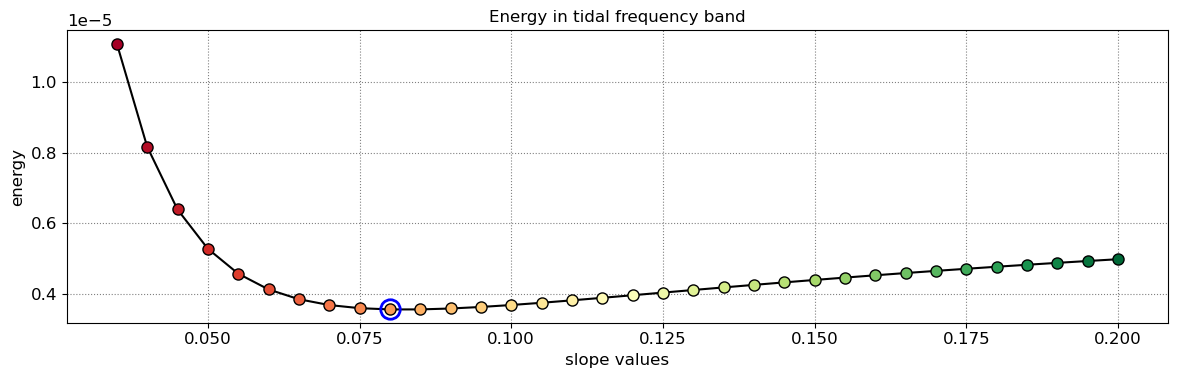

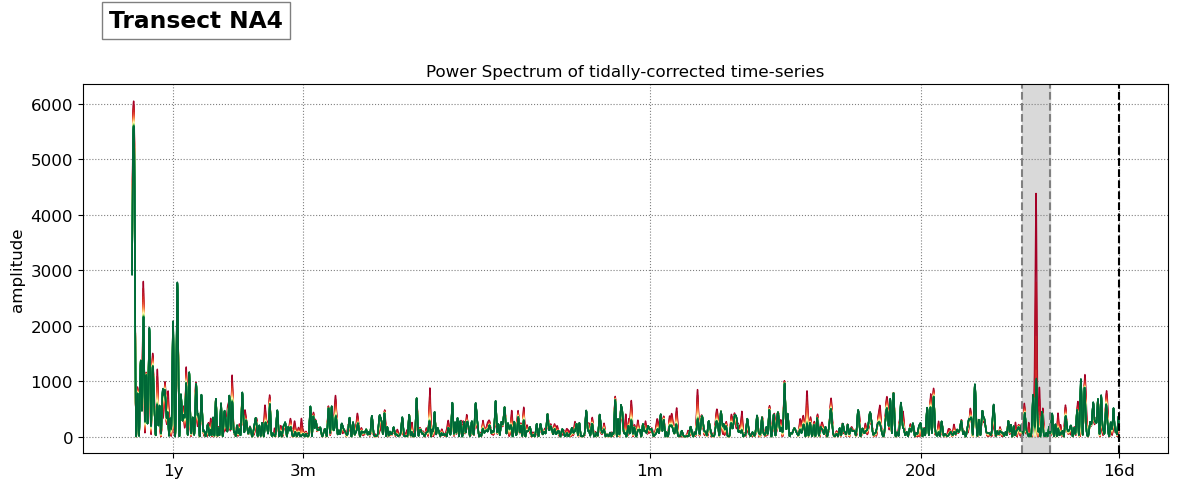

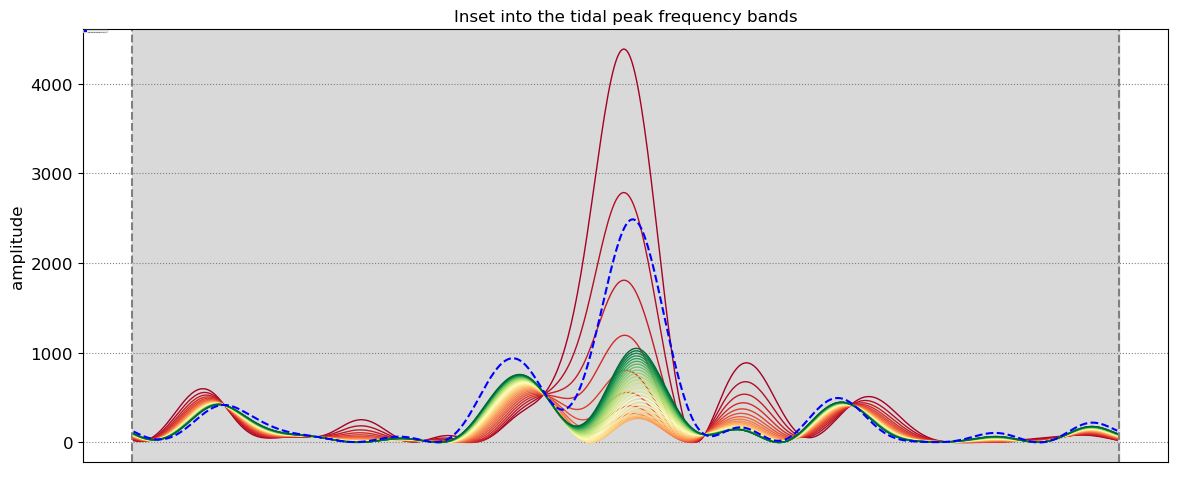

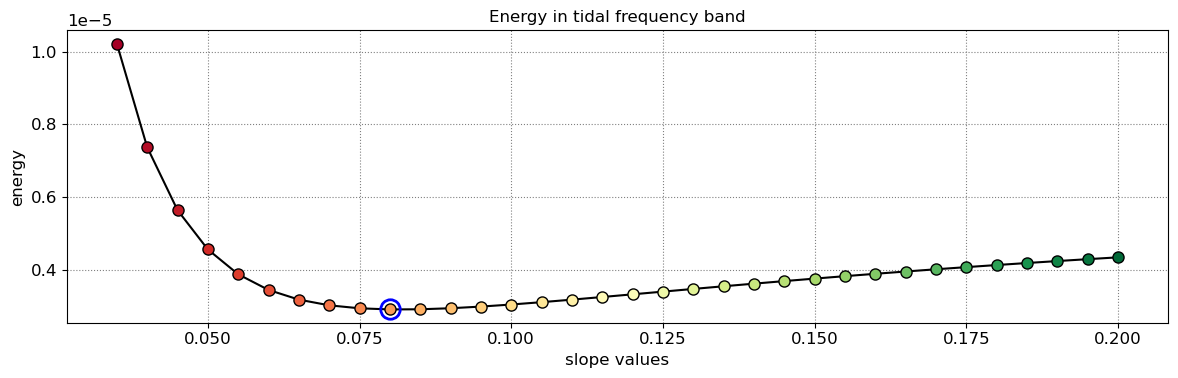

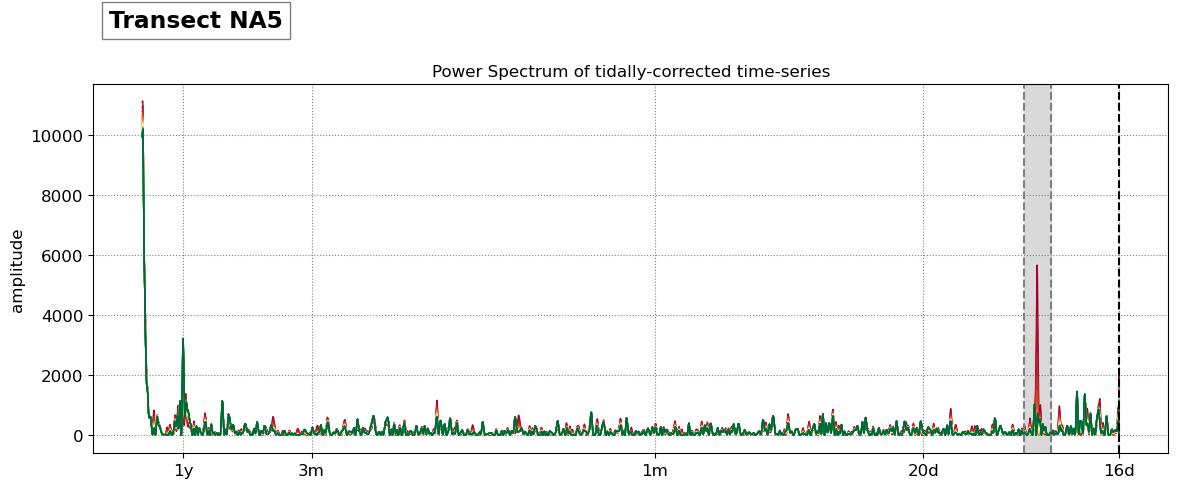

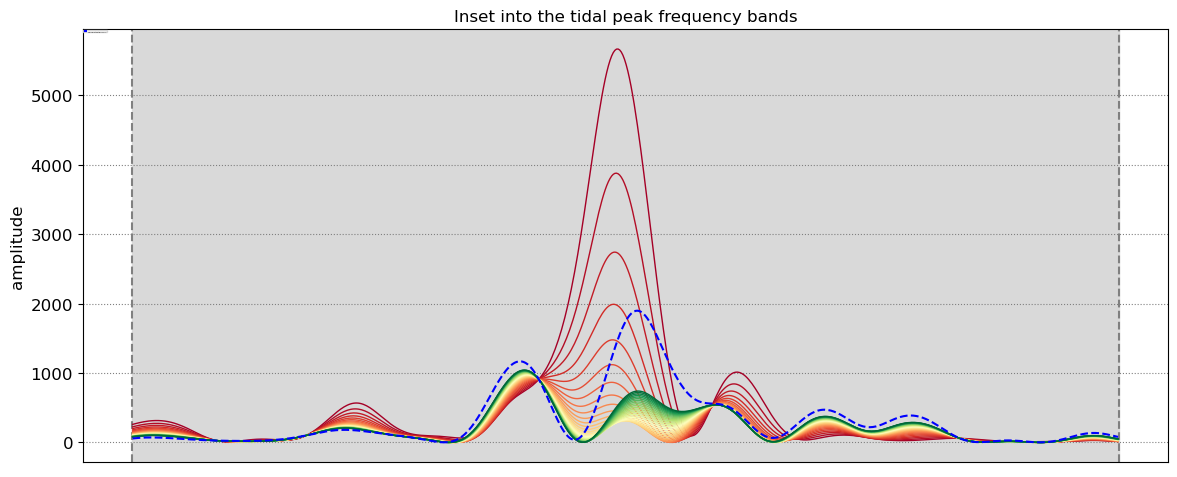

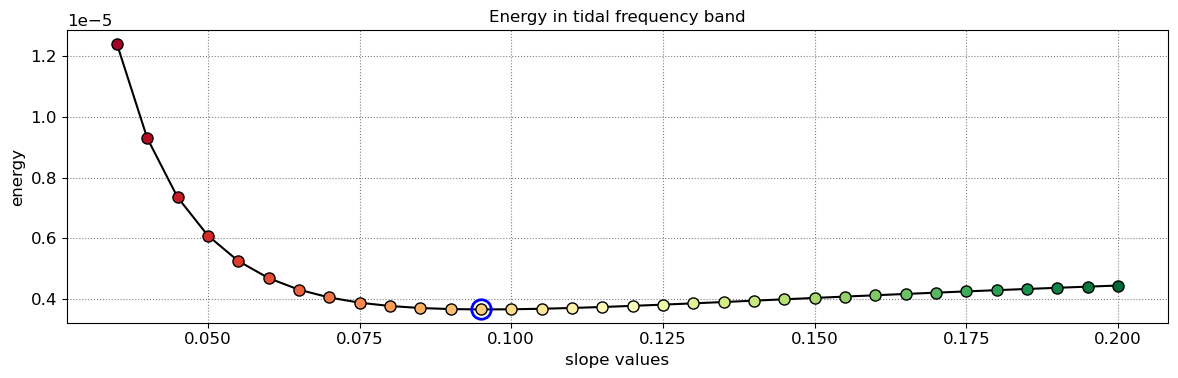

In [24]:
# estimate beach-face slopes along the transects
slope_est = dict([])
for key in cross_distance.keys():
    # remove NaNs
    idx_nan = np.isnan(cross_distance[key])
    dates = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
    tide = tide_sat[~idx_nan]
    composite = cross_distance[key][~idx_nan]
    # apply tidal correction
    tsall = SDS_slope.tide_correct(composite,tide,beach_slopes)
    title = 'Transect %s'%key
    SDS_slope.plot_spectrum_all(dates,composite,tsall,settings_slope, title)
    slope_est[key] = SDS_slope.integrate_power_spectrum(dates,tsall,settings_slope)
    print('Beach slope at transect %s: %.3f'%(key, slope_est[key]))